<a href="https://colab.research.google.com/github/natanael-2012/project-1-deep-learning-image-classification-with-cnn/blob/main/transfer/transfer_learning%20real.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Transfer learning with TensorFlow (MobileNetV2)



The base code for this was a [TensorFlow tutorial for transfer learning](https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub). I removed the unnecesary parts and loded the [Animals-10 dataset](https://www.kaggle.com/datasets/alessiocorrado99/animals10/data), used for image classification in this part of the project

## Setup
We begin importing the necessary libraries and modules. The pre-trained model we will be using is included in tensorflow

In [2]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2

from sklearn.metrics import classification_report, confusion_matrix

import datetime
# tf.keras.config.set_dtype_policy("mixed_float16")

%load_ext tensorboard

## An ImageNet classifier

The MobileNet model was pre-trained on the [ImageNet](https://en.wikipedia.org/wiki/ImageNet) benchmark dataset. MobileNet was designed for mobile and embedded vision applications, lightweight and efficient, with faster inference times, and requires less memory and computational power, even if it may not achieve the same level of accuracy as ResNet50 or InceptionV3.

Since we're supposed to build a web-app, this option sounded as the best one.

## Simple transfer learning

But what if you want to create a custom classifier using your own dataset that has classes that aren't included in the original ImageNet dataset (that the pre-trained model was trained on)?

To do that, you can:

1. Select a pre-trained model from TensorFlow; and
2. Retrain the top (last) layer to recognize the classes from your custom dataset.

### Dataset

We begin by importing the Animals-10 dataset from Kaggle. Since I have been running it on Colab and the system sometimes fails, I included the if statement to avoid continuously downloading the dataset

In [3]:
import kagglehub
import os
from pathlib import Path

# Download dataset directly from Kaggle (if running on colab)
if os.path.exists('/root/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2'):
  path = Path('/root/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2')
  print("Dataset already downloaded")
else:
  path = kagglehub.dataset_download("alessiocorrado99/animals10")


# Define the raw images path
raw_img_path = os.path.join(path, 'raw-img')  # Adjust based on the downloaded structure

# Verify dataset structure
if os.path.exists(raw_img_path):
    print("Dataset downloaded and extracted successfully!")
    print("Path to dataset files:", path)
    print("\nPath to raw images:", raw_img_path)
    print("Categories:", os.listdir(raw_img_path))  # List categories in the raw images folder
else:
    print("Error: raw-img folder not found. Please verify the dataset structure.")

100%|██████████| 586M/586M [00:26<00:00, 22.8MB/s]

Extracting files...


Dataset downloaded and extracted successfully!
Path to dataset files: /root/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2

Path to raw images: /root/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2/raw-img
Categories: ['ragno', 'gatto', 'farfalla', 'gallina', 'pecora', 'scoiattolo', 'cane', 'mucca', 'cavallo', 'elefante']


Now we "create" training and testing sets. This is to avoid having all the images in memory and loads them in batches.

In [4]:
# Parameters for preprocessing
img_size = (224, 224)  # Resize all images to 128x128 pixels
batch_size = 16  # Load data in batches of 32
img_height = 224
img_width = 224 # copied, in case they reuse it in the og tutorial


# Training data generator
print("Creating training data generator...")
train_data = tf.keras.utils.image_dataset_from_directory(
    str(raw_img_path),  # Path to raw images
    image_size=img_size,  # Resize images to 128x128
    batch_size=batch_size,  # Batch size for training
    seed = 42,
    # class_mode='categorical',  # Multi-class classification
    subset='training',  # Training data
    validation_split=0.2  # Use 20% of the data for validation
)

# Validation data generator
print("Creating validation data generator...")
val_data = tf.keras.utils.image_dataset_from_directory(
    str(raw_img_path),  # Path to raw images
    image_size=img_size,  # Resize images to 128x128
    batch_size=batch_size,  # Batch size for validation
    # class_mode='categorical',  # Multi-class classification
    seed = 42,
    subset='validation',  # Validation data
    validation_split = 0.2  # Use 20% of the data for validation
)


Creating training data generator...
Found 26179 files belonging to 10 classes.
Using 20944 files for training.
Creating validation data generator...
Found 26179 files belonging to 10 classes.
Using 5235 files for validation.


We now inspect the number of classes in the dataset

In [5]:
class_names = np.array(train_data.class_names)
print(class_names)

['cane' 'cavallo' 'elefante' 'farfalla' 'gallina' 'gatto' 'mucca' 'pecora'
 'ragno' 'scoiattolo']


And we normalize the images, so that the values are in the [0,1] range.

In [6]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_data.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = val_data.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

Finish the input pipeline by using buffered prefetching with `Dataset.prefetch`, so you can yield the data from disk without I/O blocking issues.

These are some of the most important `tf.data` methods you should use when loading data. Interested readers can learn more about them, as well as how to cache data to disk and other techniques, in the [Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance#prefetching) guide.

*Natanael's note*

When I saw this from the tutorial, I thought that this only loaded 1 batch and the last part of the model was trained with it, but its not. Here's a small explanation from Github Copilot:

> No, you are not assigning just one batch here, and you are not using a single batch when you do fit(train_ds). The cache() and prefetch() methods are used to optimize the data pipeline, but they do not limit the dataset to a single batch.
>
> Explanation:
* cache(): This method caches the dataset in memory after the first epoch. This means that the data will be read from memory in subsequent epochs, which can speed up training.
* prefetch(buffer_size=AUTOTUNE): This method overlaps the preprocessing and model execution by prefetching the next batch while the current batch is being processed. The AUTOTUNE buffer size allows TensorFlow to automatically determine the optimal buffer size.
>
> These methods do not change the number of batches in your dataset. The number of batches is determined by the size of your dataset and the batch size you specified when creating the dataset.

In [7]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Here we observe the information for the first batch

In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  print(labels_batch)
  break

(16, 224, 224, 3)
(16,)
tf.Tensor([8 4 8 7 8 7 9 2 8 8 0 7 8 6 7 5], shape=(16,), dtype=int32)


### Using the pre-trained model (after the transfer learning)

Here we are using a save file of the trained model, that is, after we used the ModelNetV2 pretrained model, changed the last layers, and trained them. This is to avoid training the model again, which is explained in the next section.

Here we are loading the model that i saved on my Google Drive. It has already been trained, and only remains to predict on new images.

In [9]:
# Here is the final pretrained model, after doing the transfer learning, changing the last layer, and trainin. Run this and proceed to predict
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define folder path
drive_folder_path = '/content/drive/My Drive/Colab Notebooks/animals10 CNN Project'
filepath=os.path.join(drive_folder_path, 'transfer_model2.keras') # add the file name to the path

# load the model
reloaded = tf.keras.models.load_model(filepath)

Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Here we are predicting the labels for the testing set

In [10]:
from sklearn.metrics import classification_report

# Make predictions on the validation data
predictions = reloaded.predict(val_ds, verbose=True)

# Convert predictions to class indices
predicted_class_indices = tf.math.argmax(predictions, axis=-1).numpy()

# Extract true labels from the validation data
true_labels = np.concatenate([y.numpy() for x, y in val_ds], axis=0)

np.save('/content/drive/My Drive/Colab Notebooks/animals10 CNN Project/predictions.npy', predicted_class_indices )
np.save('/content/drive/My Drive/Colab Notebooks/animals10 CNN Project/tue_labels.npy', true_labels )

# Convert true labels to class indices (if they are one-hot encoded)
if true_labels.ndim > 1:
    true_labels = np.argmax(true_labels, axis=1)

# Compare predictions with true labels
accuracy = np.mean(predicted_class_indices == true_labels)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

# Optionally, you can print a classification report
print(classification_report(true_labels, predicted_class_indices, target_names=val_data.class_names))

328/328 ━━━━━━━━━━━━━━━━━━━━ 26s 53ms/step
Validation Accuracy: 95.89%
              precision    recall  f1-score   support

        cane       0.97      0.95      0.96       956
     cavallo       0.95      0.96      0.96       534
    elefante       0.97      0.94      0.96       256
    farfalla       0.95      0.96      0.96       406
     gallina       0.99      0.97      0.98       641
       gatto       0.90      0.97      0.94       303
       mucca       0.91      0.92      0.92       364
      pecora       0.91      0.93      0.92       363
       ragno       0.98      0.98      0.98      1025
  scoiattolo       0.97      0.97      0.97       387

    accuracy                           0.96      5235
   macro avg       0.95      0.96      0.95      5235
weighted avg       0.96      0.96      0.96      5235



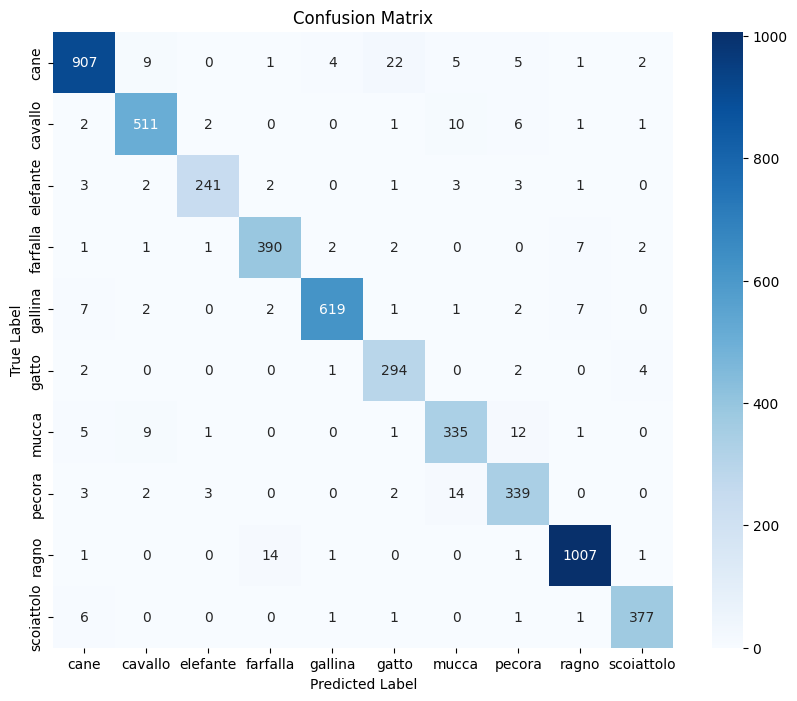

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_class_indices)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Loading MobileNetV2 (do training)

### Using MobileNetV2 for transfer learning (from the beginning)

The MobileNetV2 model is included in TensorFlow. We load it on `base_model`, giving it the input shape (image shapes), and decide if we want to change the last layer by setting `include_top=False`. We also set `base_model.trainable=False` to avoid re-training the previous layers from the MobileNetV2 model. This only allows us to train the new layers we will add.

In [ ]:
base_model = MobileNetV2(input_shape=(img_size +(3,)), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


The feature extractor returns a 1280-long vector for each image (the image batch size remains at its original size):

In [ ]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 7, 7, 1280)


#### Attach a classification head

To complete the model, wrap the feature extractor layer in a `tf.keras.Sequential` model and add a fully-connected layer for classification:

In [ ]:
num_classes = len(class_names)

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),  # Use GlobalAveragePooling2D to reduce the dimensions
    tf.keras.layers.Dense(num_classes, activation='softmax')  # Final layer with 'softmax' for classification

])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │          12,810 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# get predictions for the first batch
predictions = model(image_batch)

NameError: name 'model' is not defined

In [ ]:
predictions.shape

TensorShape([16, 10])

#### Train the model

Use `model.compile` to configure the training process and add a `tf.keras.callbacks.TensorBoard` callback to create and store logs:

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1) # Enable histogram computation for every epoch.

Now use the `Model.fit` method to train the model.

To keep this example short, you'll be training for just 10 epochs. To visualize the training progress in TensorBoard later, create and store logs an a [TensorBoard callback](https://www.tensorflow.org/tensorboard/get_started#using_tensorboard_with_keras_modelfit).

In [ ]:
#

NUM_EPOCHS = 10

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                    callbacks=tensorboard_callback)

Epoch 1/10
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 94s 63ms/step - acc: 0.8645 - loss: 1.6286 - val_acc: 0.9545 - val_loss: 1.5126
Epoch 2/10
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 73s 15ms/step - acc: 0.9613 - loss: 1.5077 - val_acc: 0.9595 - val_loss: 1.5069
Epoch 3/10
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - acc: 0.9691 - loss: 1.4975 - val_acc: 0.9589 - val_loss: 1.5059
Epoch 4/10
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - acc: 0.9743 - loss: 1.4913 - val_acc: 0.9584 - val_loss: 1.5055
Epoch 5/10
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - acc: 0.9783 - loss: 1.4877 - val_acc: 0.9587 - val_loss: 1.5041
Epoch 6/10
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - acc: 0.9804 - loss: 1.4847 - val_acc: 0.9578 - val_loss: 1.5043
Epoch 7/10
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - acc: 0.9814 - loss: 1.4830 - val_acc: 0.9601 - val_loss: 1.5041
Epoch 8/10
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - acc: 0.9831 - loss: 1.4811 - val_acc: 0.9612 - val_loss: 1.5027
Epoch 9/10
1309/1309 ━━━

#### Check the predictions

Now we can predict, like we did before

In [ ]:
predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
['ragno' 'gallina' 'ragno' 'pecora' 'ragno' 'pecora' 'scoiattolo'
 'elefante' 'ragno' 'ragno' 'cane' 'pecora' 'ragno' 'mucca' 'pecora'
 'gatto']


Plot the model predictions:

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n]) # issue here: ValueError: arrays must be of dtype byte, short, float32 or float64
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

#### Export and reload your model

Now that you've trained the model, export it as a SavedModel for reusing it later.

In [ ]:
from google.colab import drive
import os
import pickle

# Mount Google Drive
drive.mount('/content/drive')

# Define Google Drive folder path
drive_folder_path = '/content/drive/My Drive/Colab Notebooks/animals10 CNN Project'
filepath=os.path.join(drive_folder_path, 'transfer_model3.keras')
t = time.time()

# Save training history in Google Drive
history_file_path = os.path.join(drive_folder_path, 'training_history_transfer3.pkl')
with open(history_file_path, 'wb') as f:
    pickle.dump(history.history, f)
model.save(filepath)

# export_path

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Confirm that you can reload the SavedModel and that the model is able to output the same results:

In [ ]:
# reloaded = tf.keras.models.load_model(export_path)
reloaded = tf.keras.models.load_model(filepath)

In [ ]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [ ]:
abs(reloaded_result_batch - result_batch).max()

0.0

In [ ]:
reloaded_predicted_id = tf.math.argmax(reloaded_result_batch, axis=-1)
reloaded_predicted_label_batch = class_names[reloaded_predicted_id]
print(reloaded_predicted_label_batch)

['ragno' 'gallina' 'ragno' 'pecora' 'ragno' 'pecora' 'scoiattolo'
 'elefante' 'ragno' 'ragno' 'cane' 'pecora' 'ragno' 'mucca' 'pecora'
 'gatto']


In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(reloaded_predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} slice index 16 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

Error in callback <function _draw_all_if_interactive at 0x7edd8f2b7d80> (for post_execute):


ValueError: arrays must be of dtype byte, short, float32 or float64

ValueError: arrays must be of dtype byte, short, float32 or float64

<Figure size 1000x900 with 17 Axes>